#### **1. Import Necessary Modules**

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

import wordcloud
from nltk.corpus import stopwords
import string

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords', download_dir=os.curdir)
nltk.download('wordnet', download_dir=os.curdir)
nltk.download('punkt', download_dir=os.curdir)
nltk.download('averaged_perceptron_tagger',download_dir=os.curdir)
nltk.download('averaged_perceptron_tagger', download_dir=os.curdir)

[nltk_data] Downloading package stopwords to ....
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ....
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to ....
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to ....
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to ....
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### **2. Read The Data**

In [3]:
train_path = '/home/v/news-article-classification/source/train/train.csv'
test_path = '/home/v/news-article-classification/source/test/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
print(f"Train Data --> (rows: {train_df.shape[0]}, columns: {train_df.shape[1]})")
print(f"Test Data --> (rows: {test_df.shape[0]}, columns: {test_df.shape[1]})")


Train Data --> (rows: 1490, columns: 3)
Test Data --> (rows: 735, columns: 2)


In [4]:
train_df.columns = [column.lower() for column in train_df.columns]
test_df.columns = [column.lower() for column in test_df.columns]
print(f"Train dataset Columns: {list(train_df.columns)}")
print(f"Test dataset Columns: {list(test_df.columns)}")

Train dataset Columns: ['articleid', 'text', 'category']
Test dataset Columns: ['articleid', 'text']


In [5]:
train_df.head()

,articleid,text,category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


#### **EDA**

##### **Basic Feature Extraction - 1**

##### **1. Stop Words**

In [6]:
stop = stopwords.words('english')
train_df['stopwords'] = train_df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))

##### **2. Number of Punctuations**

In [7]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

train_df['punctuations'] = train_df['text'].apply(lambda x:count_punct(x))

##### **3. Number of HashTag Characters**

In [8]:
train_df['hashtags'] = train_df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

##### **4. Number of Numerics**

In [9]:
train_df['numerics'] = train_df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

##### **5. Upper Case Words**

In [10]:
train_df['upper'] = train_df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [11]:
train_df.head()

,articleid,text,category,stopwords,punctuations,hashtags,numerics,upper
0,1833,worldcom ex-boss launches defence lawyers defe...,business,108,22,0,4,0
1,154,german business confidence slides german busin...,business,120,25,0,2,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,220,36,0,17,0
3,1976,lifestyle governs mobile choice faster bett...,tech,276,42,0,4,0
4,917,enron bosses in $168m payout eighteen former e...,business,142,31,0,3,0


#### **Text Cleaning**

##### **1. Text to Lower Case**

In [12]:
train_df['text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [13]:
import re
add_words = ["mr","also","would","could","say","u"]
stop_words = set(stopwords.words("english"))
stop_added = stop_words.union(add_words)
def clean_text(text):
    text = " ".join([x.lower() for x in text.split()])
    # text = re.sub(r'\bus\b','UnitedStates', text)
    # text = re.sub(r'\buk\b','UnitedKingdom', text)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' %re.escape(string.punctuation),'', text)
    text = re.sub(r'[^a-zA-z]?\w*\d\w','', text)
    text = re.sub(r'\S*https?:\S*','', text)
    text = re.sub(r'<.*?>','', text)
    text = re.sub(r'\n',' ', text)
    text = re.sub("[''""...“”‘’…]", '', text)
    text = ' '.join([text for text in text.split() if text not in stop_added])
    text = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', text) #emojis and symbols
    text = text.strip()
    text = ' '.join([text.strip() for text in text.split()])
    return text

In [14]:
def get_wordnet_pos(tag):
    # Map POS tag to first character used by wordnet.lemmatize()
    tag = tag[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_with_pos(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # POS tag tokens
    tagged_tokens = nltk.pos_tag(tokens)
    # Create lemmatizer object
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each token with POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens]
    # Join lemmatized tokens back into text
    lemmatized_text = " ".join([token for token in lemmatized_tokens if token not in stop_added])
    return lemmatized_text

In [15]:
def remove_stopwords_after_pos(text):
    text = ' '.join([text for text in text.split() if text not in stop_added])
    return text

In [16]:
train_df['clean_text'] = train_df['text'].apply(lambda x: clean_text(x))

In [17]:
train_df['clean_text'] = train_df['clean_text'].apply(lambda x: lemmatize_with_pos(x))

In [18]:
train_df['clean_text']= train_df['clean_text'].apply(lambda x: remove_stopwords_after_pos(x))

In [19]:
words_to_remove = []
with open('words_to_remove.txt','r') as f:
    contents = f.read()
    for word in contents.split(','):
        words_to_remove.append(word)

In [20]:
train_df['clean_text'] = train_df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in words_to_remove]))

In [21]:
text = train_df[['articleid','clean_text']][train_df['articleid']==1945].values[0][1]
text

'hard act follow outkast rap duo outkast trio trophy mtv europe award crown year huge success band late triumph add three grammys four american mtv gong earlier year andre big boi album love critically acclaim since release sell large quantity around world double album saw pair produce one disc top chart time single hey ya take another track exponents southern hiphop way move displace top spot georgia pair year critical commercial triumph leave tough act follow next musical act g money presenter bbc urban music stationtra think hiatus inevitable sustained period exposure give band time think interest might appearance outside band produce artist number fringe music project andre like go act might see film big boi already dogbreeding business dj couple year back another album collaboration unlike double cd greatness become clear love see last add outkast musical career span year enjoy commercial critical success past debut go platinum take pair score first hit uk jackson album stakonia s

In [23]:
pd.DataFrame(" ".join(train_df['clean_text']).split()).value_counts()

year         1852
make         1438
new          1340
people       1323
one          1187
             ... 
nightfire       1
nighy           1
nihat           1
nihon           1
£9              1
Length: 20995, dtype: int64

##### **Sentence Level Data Analysis**

In [24]:
train_df['sentence_len'] = train_df['clean_text'].str.len()

Max Length: 10701, Min Length: 320, Average Length: 1400


<AxesSubplot: >

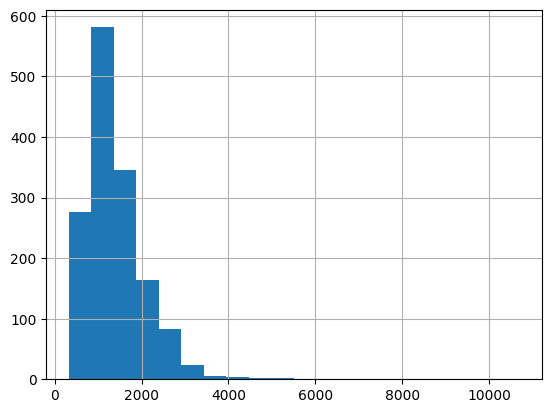

In [25]:
print(f"Max Length: {max(train_df['sentence_len'])}, Min Length: {min(train_df['sentence_len'])}, Average Length: {int(train_df['sentence_len'].mean())}")
train_df['sentence_len'].hist(bins=20)

##### **Word Level Analysis**

Sentence Max Words: 1584, Min Words:47, Average Words: 202


<AxesSubplot: >

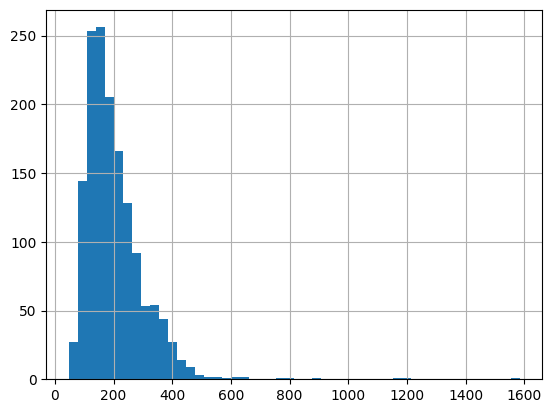

In [26]:
train_df['word_len'] = train_df['clean_text'].str.split().map(lambda x: len(x))
print(f"Sentence Max Words: {max(train_df['word_len'])}, Min Words:{min(train_df['word_len'])}, Average Words: {int(train_df['word_len'].mean())}")
train_df['word_len'].hist(bins=50)

Average Words Length: 7, Min Words:5, Average Words: 5


<AxesSubplot: >

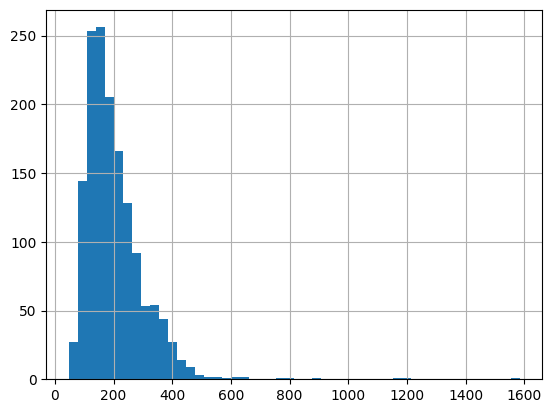

In [27]:
train_df['avg_word_len'] = train_df['clean_text'].str.split().apply(lambda x: [len(i) for i in x ]).map(lambda x: np.mean(x))
print(f"Average Words Length: {int(max(train_df['avg_word_len']))}, Min Words:{int(min(train_df['avg_word_len']))}, Average Words: {int(train_df['avg_word_len'].mean())}")
train_df['word_len'].hist(bins=50)

In [28]:
text = ' '.join([text for text in train_df['clean_text']])
words_list = text.split(' ')
word_freq = {}
for word in set(words_list):
    word_freq[word] = words_list.count(word)

In [30]:
df_word= pd.DataFrame(word_freq.items(),columns=['word','count'])
df_word['word_len'] = df_word['word'].apply(lambda x: len(x))
df_word.head()

,word,count,word_len
0,mad,8,3
1,finishing,1,9
2,eyre,3,4
3,jp,19,2
4,pcowning,1,8


In [ ]:
# words_len_gt12_count_lt3 = df_word[['word','count', 'word_len']][(df_word['count'] < 3) & (df_word['word_len'] >= 12)]
# words_len_gt12_count_lt3.to_csv('words_len_gt12_count_lt3.csv')

In [32]:
words_len_gt12 = df_word[['word','count', 'word_len']][df_word['word_len'] >= 12]
words_len_gt12.to_csv('words_len_gt12.csv')

In [34]:
import wordninja
words_to_replace = []
for word in words_len_gt12['word']:
    new_word = ' '.join(wordninja.split(word))
    words_to_replace.append(new_word)

In [36]:
words_len_gt12['new_word'] = words_to_replace
words_len_gt12.to_csv('words_len_gt12.csv')

In [38]:
df_word_replace = pd.read_csv('word_len_gt12.csv')
df_word_replace.set_index('word', inplace=True)
df_word_replace.head()

,Unnamed: 0,count,word_len,new_word
word,,,,
houstonbased,36,1,12,houston based
speechwriting,42,2,13,speech writing
unenforceable,61,2,13,unenforceable
predominately,62,2,13,predominately
infrastructure,89,24,14,infra structure


In [45]:
import pickle

In [48]:
df_word_replace_dict = dict(df_word_replace['new_word'])

In [49]:
with open('df_word_replace_dict.pickle','wb') as f:
    pickle.dump(df_word_replace_dict, f)

In [55]:
with open('df_word_replace_dict.pickle', 'rb') as f:
    data = pickle.load(f)
    print(data)


{'houstonbased': 'houston based', 'speechwriting': 'speech writing', 'unenforceable': 'unenforceable', 'predominately': 'predominately', 'infrastructure': 'infra structure', 'irreversible': 'irreversible', 'consistently': 'consistently', 'depreciation': 'depreciation', 'wellorganised': 'well organised', 'coproductions': 'co productions', 'geoscientists': 'geo scientists', 'contributing': 'contributing', 'homosexuality': 'homo sexuality', 'hypertension': 'hyper tension', 'londonfrankfurt': 'london frankfurt', 'conferencing': 'conferencing', 'dysfunctional': 'dysfunctional', 'userfriendly': 'user friendly', 'lowprevalence': 'low prevalence', 'quickgrowing': 'quick growing', 'egyptianborn': 'egyptian born', 'oceanography': 'oceanography', 'lifeextending': 'life extending', 'semimythical': 'semi mythical', 'undergraduate': 'under graduate', 'instinctively': 'instinctively', 'remotecontrol': 'remote control', 'globalisation': 'globalisation', 'agricultural': 'agricultural', 'revolutionised'

In [56]:
train_df['clean_text'] = train_df['clean_text'].replace(df_word_replace_dict, regex=True)

In [ ]:
with open("words_to_remove.txt", "w") as f:
    f.writelines(",".join(words_to_remove))

In [ ]:
words_to_remove.to_csv('words_to_remove.csv')

In [59]:
train_df['category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: category, dtype: int64

In [60]:
sport_df = train_df[train_df['category']=='sport']
business_df = train_df[train_df['category']=='business']
politics_df = train_df[train_df['category']=='politics']
entertainment_df = train_df[train_df['category']=='entertainment']
tech_df = train_df[train_df['category']=='tech']

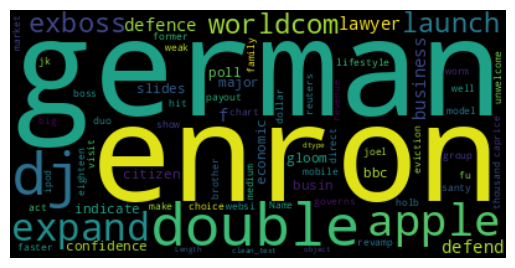

In [73]:
text = train_df['clean_text'].apply(lambda x: ' '.join(x.split()))
# Create a wordcloud object
wordcloud = WordCloud().generate(str(text))

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


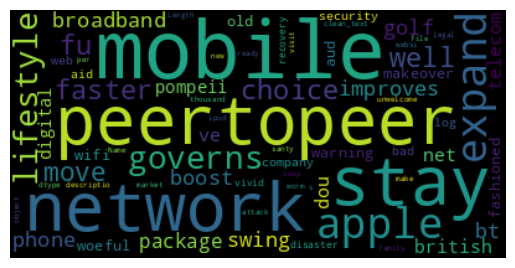

In [72]:
text = tech_df['clean_text'].apply(lambda x: ' '.join(x.split()))
# Create a wordcloud object
wordcloud = WordCloud().generate(str(text))

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


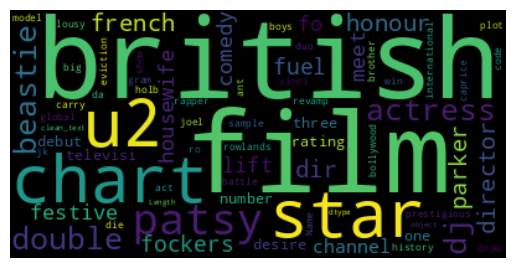

In [71]:
text = entertainment_df['clean_text'].apply(lambda x: ' '.join(x.split()))
# Create a wordcloud object
wordcloud = WordCloud().generate(str(text))

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


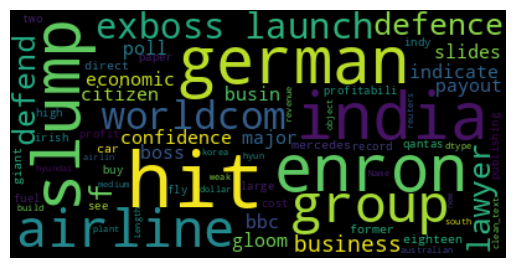

In [69]:
text = business_df['clean_text'].apply(lambda x: " ".join(x.split()))
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

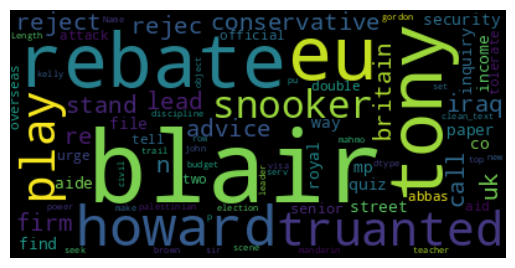

In [70]:
text = politics_df['clean_text'].apply(lambda x: ' '.join(x.split()))
# Create a wordcloud object
wordcloud = WordCloud().generate(str(text))

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


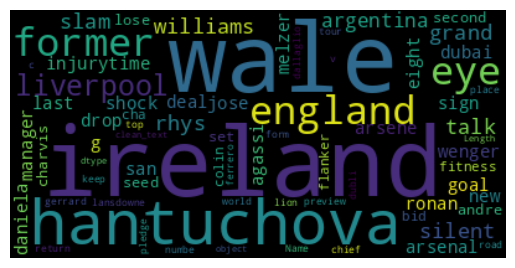

In [68]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = sport_df['clean_text'].apply(lambda x: ' '.join(x.split()))
# Create a wordcloud object
wordcloud = WordCloud().generate(str(text))

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [74]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = train_df['clean_text']
y = train_df['category']

X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=19)